# GMsFEM: Case without parameter

In [1]:
import math
import scipy.linalg
import numpy as np

from ufl import *
from dolfin import *

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from gmsfem import MsFEM
from utils import generate_mask

## MWE: 2 клетки ниже  
* 1 клетка - генерация маски, чтобы позже определить коэффициент проницаемости, как функцию заданную в вершинах конечных элементов (это в частности накладывает ограничения на выбор пространства функций для решения задачи)  
* 2 клетка - решение однородной задачи вида $\mathrm{div}(\kappa\nabla u) = 0$ в некоторой окрестности узла грубой сетки для гран. условия в виде дельта-функции в точке на границе (перебор всех граничных точек)

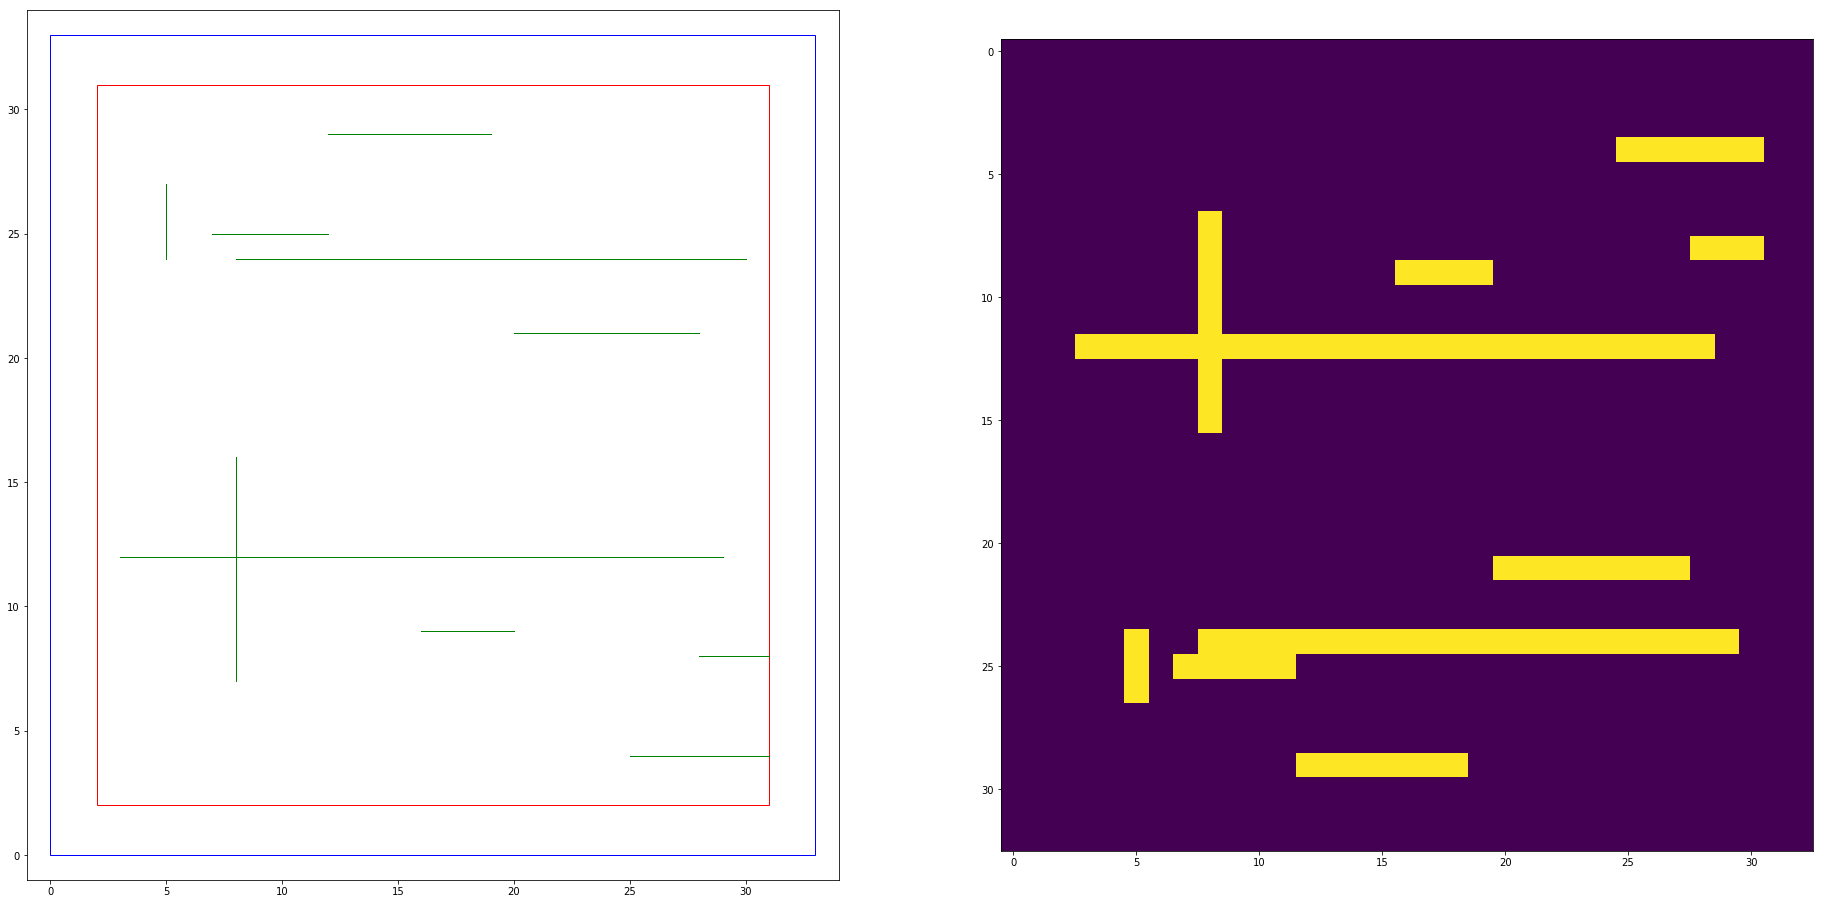

In [19]:
# Mask Generation
N_el = 32
win = N_el // 16
side = N_el + 1 - 2*win

n_strips = N_el // 3
n_ver = np.random.binomial(n_strips, p=.5)
n_hor = n_strips - n_ver

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))
ax1.set_xlim(-1, N_el+2)
ax1.set_ylim(-1, N_el+2)
ax1.add_patch(Rectangle((0, 0), N_el+1, N_el+1, lw=1, fc='none', ec='b'));
ax1.add_patch(Rectangle((win, win), side, side, lw=1, fc='none', ec='r'));

mask = np.zeros((N_el+1, N_el+1), dtype='bool')
for pos, n_lines in zip((0, 1), (n_ver, n_hor)):
    ends = [None] * 2
    ends[0] = np.random.choice(side, n_lines, replace=False) + win
    ends[1] = np.random.choice(side, n_lines, replace=False) + win
    lengths = np.ceil(np.random.rand(n_lines) * (side+win-ends[pos])).astype('int')
    for l, x1, x2 in zip(lengths, *ends):
        if pos:
        # vertical lines
            xdata = [x1] 
            ydata = [x2, x2+l]
            mask[x2:x2+l, x1] = True
        else: 
        # horizontal lines
            xdata = [x1, x1+l]
            ydata = [x2]
            mask[x2, x1:x1+l] = True

        ax1.add_line(Line2D(xdata, ydata, lw=1, c='g'))
ax2.imshow(mask);

In [20]:
def set_kappa(eta, mask, V):
    """
    Set permeability coefficient
    """
    kappa = Function(V)
    v2d = vertex_to_dof_map(V)
    dofs, = mask.flatten().nonzero()
    kappa.vector()[:] = 1
    kappa.vector()[v2d[dofs]] = eta
    
    return kappa

tol = 1./N_el
def set_boundary(p, src):
    """
    Delta function bc
    """
    predicate_1 = near(p[0], src[0], tol)
    predicate_2 = near(p[1], src[1], tol)

    return predicate_1 and predicate_2

mesh = UnitSquareMesh(2*n_el, 2*n_el)
mesh.scale(2./n_blocks)
V = FunctionSpace(mesh, 'P', 1)
u = TrialFunction(V)
v = TestFunction(V)
#kappa = set_kappa(1e2, mask_[i*n_el:(i+2)*n_el+1, j*n_el:(j+2)*n_el+1] , V)

a = dot(grad(u), grad(v)) * dx
#a = kappa * dot(grad(u), grad(v)) * dx
L = Constant(0.) * v * dx
A = assemble(a)
b = assemble(L)

U, DU = [], []
bmesh = BoundaryMesh(mesh, 'local')
build = np.vectorize(assemble, [float])
every = lambda x, on: on

for src in bmesh.coordinates():
    single = lambda x: set_boundary(x, src)
    bc1 = DirichletBC(V, Constant(0.), every)
    bc2 = DirichletBC(V, Constant(1.), single, 'pointwise')
    bcs = [bc1, bc2]
    
    b_loc = b.copy()
    A_loc = A.copy()
    for bc in bcs:
        bc.apply(A_loc, b_loc)

    u = Function(V)
    solve(A_loc, u.vector(), b_loc)
    U.append(u)
    DU.append(grad(u))

A = build(np.outer(U, U) * dx)  # mass matrix
S = build(np.tensordot(DU, DU, [1, 1]) * dx)  # stiffness matrix
# A = build(kappa * np.outer(U, U) * dx)
# S = build(kappa * np.tensordot(DU, DU, [1, 1]) * dx)
w, v = scipy.linalg.eigh(A, S)

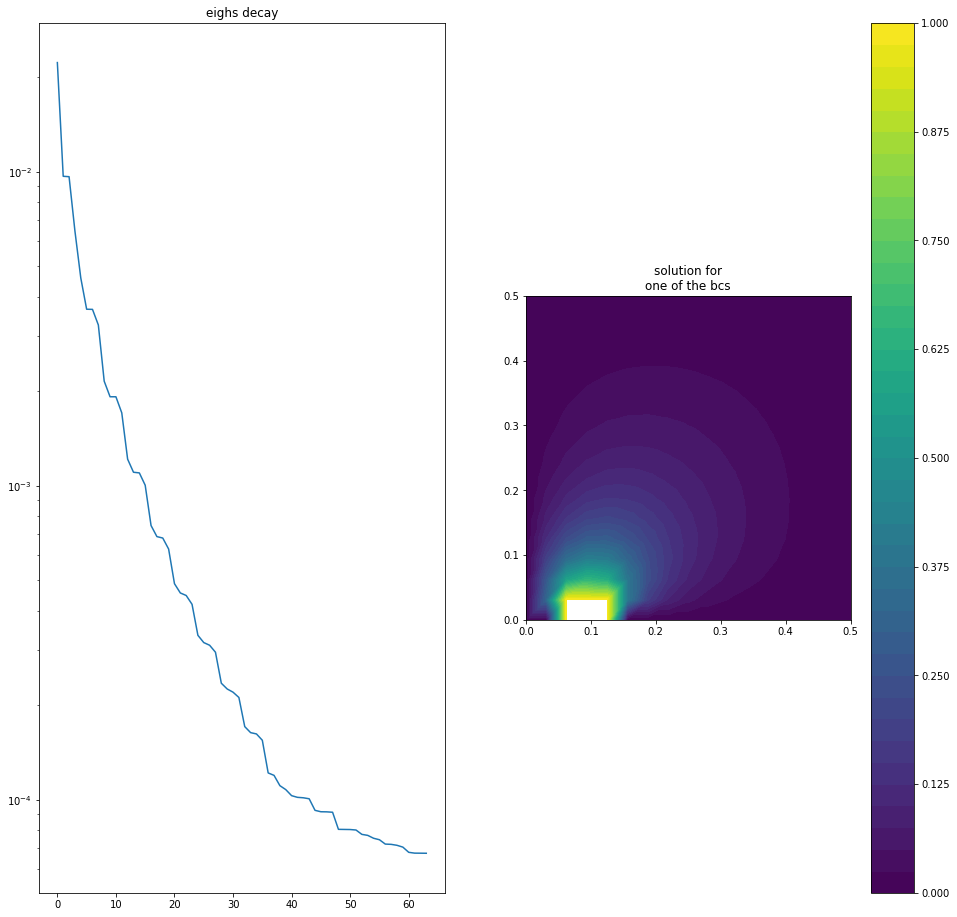

In [21]:
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.title('eighs decay')
plt.plot(w[::-1])
plt.yscale('log')

plt.subplot(122)
plt.title('solution for\none of the bcs')
p = plot(U[4])
plt.colorbar(p);

---
## Весь алгоритм целиком

In [2]:
n_el = 8  #  number of elements in a coarse block
n_blocks = 4  #  number of coarse blocks along 1D
N_el = n_el * n_blocks  #  number of total elements along an axis
M_off = 10  #  number of eigenvalues to keep
eta = 1e3 # permeability value for second continuum

rhs = 'sin(2*pi*x[0])*sin(2*pi*x[1])'
#rhs = 'exp(-pow(x[0]-.5, 2) - pow(x[1]-.5, 2))'
mask = generate_mask(N_el//8, N_el, N_el//16, seed=1234)

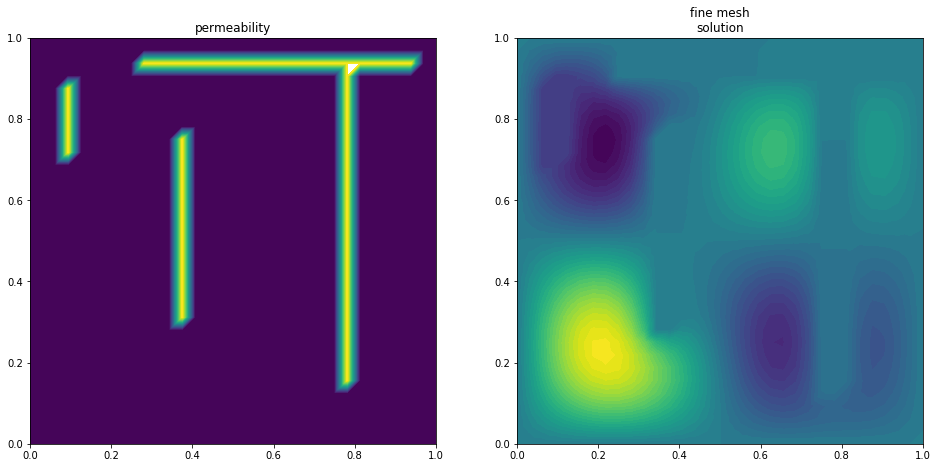

In [3]:
ms_solver1 = MsFEM(n_el, n_blocks, mask, rhs, eta, n_eighs=M_off, pi=math.pi)
ms_solver2 = MsFEM(n_el, n_blocks, mask, rhs, eta, n_eighs=2*M_off, pi=math.pi)
u_f = ms_solver1.getFineMeshSolution()

M = UnitSquareMesh(n_blocks, n_blocks)
W = FunctionSpace(M, 'P', 1)
u_c = Function(W)
LagrangeInterpolator.interpolate(u_c, u_f);

plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.title('permeability')
plot(ms_solver1._kappa[-1])

plt.subplot(122)
plt.title('fine mesh\nsolution')
plot(u_f);

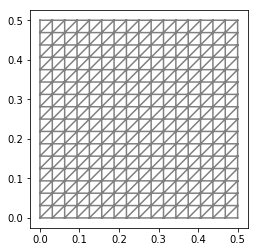

In [6]:
plot(ms_solver1.V[0].mesh());

In [7]:
%%time
ms_solver1.buildSnapshotSpace()
ms_solver1.buildOfflineSpace()

CPU times: user 1min 51s, sys: 1.42 s, total: 1min 52s
Wall time: 1min 50s


In [8]:
%time
ms_solver2.buildSnapshotSpace()
ms_solver2.buildOfflineSpace()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [9]:
%%time
u_c1 = ms_solver1.globalCoupling()

CPU times: user 9.33 s, sys: 47.3 ms, total: 9.38 s
Wall time: 9.37 s


In [10]:
%%time
u_c2 = ms_solver2.globalCoupling()

CPU times: user 25.6 s, sys: 142 ms, total: 25.7 s
Wall time: 25.6 s


0.0011493205286798969
0.0011314360693553084


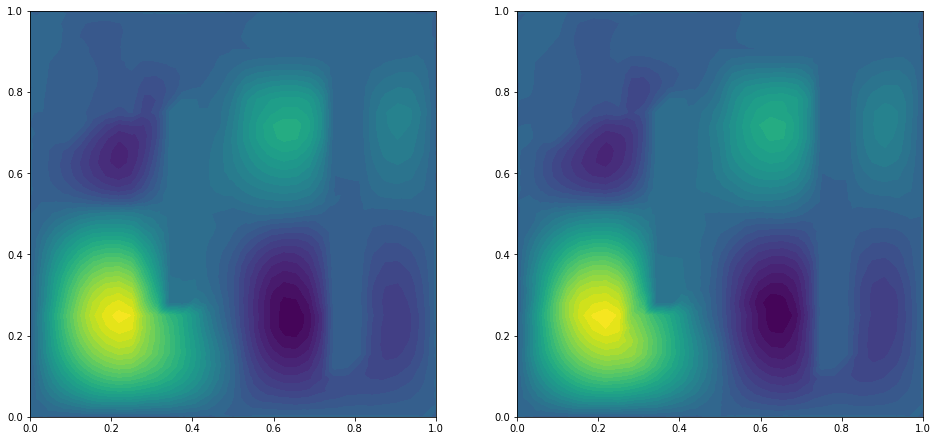

In [11]:
print(norm(project(u_c1 - u_f, ms_solver1.W)))
print(norm(project(u_c2 - u_f, ms_solver1.W)))

plt.figure(figsize=(16, 16))
plt.subplot(121)
plot(u_c1);

plt.subplot(122)
plot(u_c2);